In [1]:
import os
os.environ["MAIN_DIR"] = ""

In [2]:
from rdkit import Chem
import pickle
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt
import tqdm
import itertools
from tabulate import tabulate
import io, base64
from PIL import Image

from action_utils import *

In [3]:
from torchdrug import data

# Data

In [6]:
start_mols = pickle.load(open("datasets/my_uspto/unique_start_mols.pickle", 'rb'))

In [38]:
from multiprocessing import Pool
import time

main_df = pd.DataFrame(columns=['reactant', 'rsub', 'rcen', 'rsig', 'rsig_cs_indices', 'psub', 'pcen', 'psig', 'psig_cs_indices', 'product'])
N = 10000
np.random.seed(42)
steps = 1

def generate_train_data(smile):
    mol = Chem.MolFromSmiles(smile)

    df = pd.DataFrame(columns=['reactant', 'rsub', 'rcen', 'rsig', 'rsig_cs_indices', 'psub', 'pcen', 'psig', 'psig_cs_indices', 'product'])
    index = []
    
    # Get sequences
    try:
        for i in range(steps):
            actions = get_applicable_actions(mol)
            if actions.shape[0] == 0:
                break

            # Apply a random action
            rand_idx = np.random.randint(0, actions.shape[0])
            product = apply_action(mol, *actions.iloc[rand_idx])

            # Add it to df
            df.loc[df.shape[0], :] = [Chem.MolToSmiles(mol)] + actions.iloc[rand_idx].tolist() + [Chem.MolToSmiles(product)]
            index.append(actions.iloc[rand_idx].name)

            # Next reactant = product
            mol = product
    except Exception as e:
        return pd.DataFrame(columns=['reactant', 'rsub', 'rcen', 'rsig', 'rsig_cs_indices', 'psub', 'pcen', 'psig', 'psig_cs_indices', 'product'])
    
    # Fix index
    df.index = index
    
    # Make combinations for multi-step possibilities of source-->target
    for i in range(df.shape[0]-1, 0, -1):
        new_df = df.iloc[:i].copy()
        new_df["product"] = df.iloc[i]["product"]
        df = pd.concat([df, new_df])
        
    return df

df_list = []
final_shape = 0
# Create dataset for 1 step pred
with Pool(30) as p, tqdm.tqdm(total=N) as pbar:
    while final_shape < N:
        smiles = np.random.choice(start_mols, size=(1000,))

        for new_df in p.imap_unordered(generate_train_data, smiles, chunksize=10):
            df_list.append(new_df)
            final_shape += new_df.shape[0]

        pbar.update(final_shape - pbar.n)

main_df = pd.concat(df_list)
del df_list
print(main_df.shape)


10302it [00:27, 373.17it/s]                                                                          


(10302, 10)


# Helper functions

In [40]:
def molecule_from_smile(smile):
    try:
        mol = data.Molecule.from_smiles(smile, atom_feature="pretrain", bond_feature="pretrain")
    except Exception as e:
        mol = data.Molecule.from_smiles(smile, atom_feature="pretrain", bond_feature="pretrain", with_hydrogen=True)
    return mol

def get_mol_embedding(model, smiles):
    # deepchem - attribute masking
    if isinstance(smiles, str):
        mol = molecule_from_smile(smiles)
    elif isinstance(smiles, list) or isinstance(smiles, pd.Series):
        mol = list(map(molecule_from_smile, smiles))
        mol = data.Molecule.pack(mol)
    else:
        mol = smiles
    mol = mol.to(device)
    emb = model(mol, mol.node_feature.float())["graph_feature"]
    return emb.detach()

def get_atom_embedding(model, smiles, idx):
    try:
        mol = data.Molecule.from_smiles(smiles, atom_feature="pretrain", bond_feature="pretrain")
        emb = model(mol, mol.node_feature.float())["node_feature"][idx]
    except Exception as e:
        mol = data.Molecule.from_smiles(smiles, atom_feature="pretrain", bond_feature="pretrain", with_hydrogen=True)
        emb = model(mol, mol.node_feature.float())["node_feature"][idx]
    return emb.detach()

def get_action_embedding(model, action_df):
    rsub, rcen, rsig, _, psub, pcen, psig, __ = [action_df[c] for c in action_df.columns]
    embedding = torch.concatenate([
                        get_mol_embedding(model, rsig), 
                        get_mol_embedding(model, psig)
                    ], axis=1)
    return embedding

def get_action_embedding_from_packed_molecule(model, rsig, psig):
    embedding = torch.concatenate([
                            get_mol_embedding(model, rsig), 
                           get_mol_embedding(model, psig)
                    ], axis=1)
    return embedding

# Load models

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim

In [42]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [43]:
%matplotlib inline
class NeuralNet(nn.Module):
    def __init__(self, input_size, output_size, num_hidden=1, hidden_size=50):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.hidden_layers = nn.ModuleList()
        for i in range(num_hidden):
            self.hidden_layers.append(nn.Linear(hidden_size, hidden_size))
            self.hidden_layers.append(nn.BatchNorm1d(hidden_size))
            self.hidden_layers.append(nn.ReLU())
            
        self.last_layer = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)
        for layer in self.hidden_layers:
            out = layer(out)
        out = self.last_layer(out)
        return out

class PolicyNetwork(nn.Module):
    def __init__(self):
        super(PolicyNetwork, self).__init__()
        self.GIN = torch.load("models/zinc2m_gin.pth")
        self.DENSE = torch.load("datasets/my_uspto/supervised_zinc_gin/mse_model.pth")
    
    def forward(self, x1, x2):
        out1 = self.GIN(x1, x1.node_feature.float())["graph_feature"]
        out2 = self.GIN(x2, x2.node_feature.float())["graph_feature"]
        
        out = torch.concatenate([out1, out2], axis=1)
        out = self.DENSE(out)
        return out

class CriticNetwork(nn.Module):
    def __init__(self):
        super(CriticNetwork, self).__init__()
        self.GIN = torch.load("models/zinc2m_gin.pth")
        self.DENSE = NeuralNet(self.GIN.output_dim*4, 1, num_hidden=2, hidden_size=256).to(device)
    
    def forward(self, x1, x2, x3, x4):
        out1 = self.GIN(x1, x1.node_feature.float())["graph_feature"]
        out2 = self.GIN(x2, x2.node_feature.float())["graph_feature"]
        out3 = self.GIN(x3, x3.node_feature.float())["graph_feature"]
        out4 = self.GIN(x4, x4.node_feature.float())["graph_feature"]
        
        out = torch.concatenate([out1, out2, out3, out4], axis=1)
        out = self.DENSE(out)
        return out
    
class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.GIN = torch.load("models/zinc2m_gin.pth")
        self.actor = NeuralNet(self.GIN.output_dim*2, self.GIN.output_dim*2, num_hidden=3, hidden_size=500)
        self.critic = NeuralNet(self.GIN.output_dim*4, 1, num_hidden=2, hidden_size=256)
    
    def forward(self, reac, prod, rsig, psig, out_type="both"):
        '''
        If out_type="actor", returns actions
        If out_type="critic", returns q_value
        If out_type="both", returns [actions, q_value]
        '''
        reac_out = self.GIN(reac, reac.node_feature.float())["graph_feature"]
        prod_out = self.GIN(prod, prod.node_feature.float())["graph_feature"]
    
        output = []
        if out_type in ["both", "actor"]:
            output.append(self.actor(torch.concatenate([reac_out, prod_out], axis=1)))

        if out_type in ["both", "critic"]:
            psig_out = self.GIN(psig, psig.node_feature.float())["graph_feature"]
            rsig_out = self.GIN(rsig, rsig.node_feature.float())["graph_feature"]
            output.append(self.critic(torch.concatenate([reac_out, prod_out, rsig_out, psig_out], axis=1)))
        
        if len(output) == 1:
            return output[0]
        return output

# Action dataset

In [44]:
action_dataset = pd.read_csv("datasets/my_uspto/action_dataset-filtered.csv", index_col=0)
action_dataset = action_dataset.loc[action_dataset["action_tested"] & action_dataset["action_works"]]
action_dataset = action_dataset[["rsub", "rcen", "rsig", "rbond", "psub", "pcen", "psig", "pbond"]]
print(action_dataset.shape)

action_emb_batch_size = 2**10
def get_action_dataset_embeddings(model):
    action_embeddings = []
    for i in tqdm.tqdm(range(0, action_dataset.shape[0], action_emb_batch_size)):
        action_embeddings.append(get_action_embedding(model, action_dataset.iloc[i:i+action_emb_batch_size]))
    action_embeddings = torch.concatenate(action_embeddings)
    return action_embeddings

(89384, 8)


# Testing critic only

### 1 step

In [ ]:
%%time 
test_reactants = data.Molecule.pack(list(map(molecule_from_smile, main_df_dict[1]["reactant"]))).to(device)
test_products = data.Molecule.pack(list(map(molecule_from_smile, main_df_dict[1]["product"]))).to(device)
test_rsigs = data.Molecule.pack(list(map(molecule_from_smile, main_df_dict[1]["rsig"]))).to(device)
test_psigs = data.Molecule.pack(list(map(molecule_from_smile, main_df_dict[1]["psig"]))).to(device)

In [107]:
print(test_reactants.batch_size, test_products.batch_size, test_rsigs.batch_size, test_psigs.batch_size,)

10302 10302 10302 10302


In [46]:
critic_1step = torch.load("models/supervised/critic/1step.pth").to(device)
critic_1step.eval()
pass

In [47]:
action_embeddings = get_action_dataset_embeddings(critic_1step.GIN)

  6%|███▋                                                             | 5/88 [00:13<03:25,  2.47s/it]/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Li`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `K`
  warnings.warn("Unknown value `%s`" % x)
 47%|█████████████████████████████▊                                  | 41/88 [01:46<02:02,  2.61s/it]/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Ga`
  warnings.warn("Unknown value `%s`" % x)
 60%|██████████████████████████████████████▌                         | 53/88 [02:19<01:37,  2.79s/it]/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:

In [53]:
def get_emb_indices_and_correct_idx(row):
    if isinstance(row, tuple): # For pandas iterrows
        row = row[1]
    
    # Applicable indices
    applicable_actions_df = get_applicable_actions(Chem.MolFromSmiles(row["reactant"]))
    if applicable_actions_df.shape[0] == 0:
        # If there are no applicable actions detected (rdkit problems)
        indices_used_for_data = np.where((action_dataset.index == row.name))[0]
        correct_idx = 0
    else:
        indices_used_for_data = np.where(action_dataset.index.isin(applicable_actions_df.index))[0]
        
        # Correct index
        applicable_actions_df = applicable_actions_df.loc[action_dataset.iloc[indices_used_for_data].index]
        correct_idx = indices_used_for_data[(applicable_actions_df.index == row.name).argmax()]
    
    return indices_used_for_data, correct_idx

# I'm storing as lists, so doing numpy operations for the elements
correct_indices = []
action_embedding_indices = []

# for indices_used_for_data, correct_idx in tqdm.tqdm(map(get_emb_indices_and_correct_idx, main_df.iterrows()), total=main_df.shape[0]):
# with Pool(20) as p:
    # for indices_used_for_data, correct_idx in tqdm.tqdm(p.imap(get_emb_indices_and_correct_idx, main_df.iterrows(), chunksize=50), total=main_df.shape[0]):
for row in tqdm.tqdm(main_df.iterrows(), total=main_df.shape[0]):
    indices_used_for_data, correct_idx = get_emb_indices_and_correct_idx(row)
    action_embedding_indices.append(indices_used_for_data)
    correct_indices.append(correct_idx)

  0%|                                                                      | 0/10302 [00:00<?, ?it/s]

1 Matches found!!!
[CH2:0]=[CH:1][c:2]1[cH:3][n:4]2[n:5][cH:6][n:7][cH:8][c:9]2[c:10]1-[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1
[CH2:0]=[CH:1][c:2]1[cH:3][n:4]2[n:5][cH:6][n:7][cH:8][c:9]2[c:10]1-[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1
[CH2:0]=[CH:1][c:2]1[cH:3][n:4]2[n:5][cH:6][n:7][cH:8][c:9]2[c:10]1-[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1



AssertionError: WHAT!? 51138 vs 2

In [53]:
# Make training data
def make_data(args):
    i, negative_topk = args
    data = []
    targets = []
    act_emb_for_i, correct_index = action_embeddings[action_embedding_indices[i]], correct_indices[i]

    # Positive
    positive = act_emb_for_i[correct_index]

    # Calc negatives
    dist = torch.linalg.norm(action_embeddings - positive, axis=1)
    sorted_idx = torch.argsort(dist)[:negative_topk] 
    sorted_idx = sorted_idx[sorted_idx != correct_index] # Remove correct index in list
    
    data = torch.Tensor([(i, correct_index)]+list(zip([i] * len(sorted_idx), sorted_idx)))
    targets = [1] + [0] * len(sorted_idx)
    return data, targets

test_X = []
test_Y = []
start, end = 0, main_df.shape[0]
for i in tqdm.tqdm(range(end)):
    X, Y = make_data((i, 1)) 
    test_X.append(X)
    test_Y.append(Y)

100%|█████████████████████████████████████████████████████████| 10891/10891 [00:14<00:00, 757.52it/s]


In [89]:
test_X[0:10]

tensor([[0.0000e+00, 0.0000e+00],
        [0.0000e+00, 8.7323e+04],
        [1.0000e+00, 5.0000e+00],
        [1.0000e+00, 8.9376e+04],
        [2.0000e+00, 4.0000e+00],
        [2.0000e+00, 3.7763e+04],
        [3.0000e+00, 2.6200e+02],
        [3.0000e+00, 5.4700e+02],
        [4.0000e+00, 4.0000e+00],
        [4.0000e+00, 3.7763e+04]])

In [76]:
test_X

tensor([[0.0000e+00, 0.0000e+00],
        [0.0000e+00, 8.7323e+04],
        [1.0000e+00, 5.0000e+00],
        ...,
        [1.0889e+04, 4.2500e+02],
        [1.0890e+04, 2.0000e+00],
        [1.0890e+04, 8.3049e+04]])

In [93]:
for i, j in enumerate(test_X[0:10:2, 1]):
    i, j = int(i), int(j)
    print(i, j)
    print(main_df.iloc[i]["rsig"])
    print(action_dataset.iloc[j]["rsig"])
    print()


0 0
[cH:0]1[cH:1][c:2](-[n:3]2[cH:4][c:5](-[c:6]3[cH:7][cH:8][cH:9][c:10]([NH2:11])[cH:12]3)[c:13]3[cH:14][cH:15][c:16](-[c:17]4[cH:18][cH:19][cH:20][cH:21][cH:22]4)[cH:23][c:24]23)[n:25][cH:26][n:27]1
[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[cH:7][cH:8][cH:9][n:10][cH:11]1

1 5
[CH3:0][CH2:1][S:2][C:3]([CH2:4][CH3:5])([CH:6]([F:7])[F:8])[S:9](=[O:10])[CH2:11][CH3:12]
[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[cH:7][cH:8][cH:9][n:10][cH:11]1

2 4
[CH3:0][c:1]1[cH:2][cH:3][cH:4][cH:5][cH:6]1
[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[cH:7][cH:8][cH:9][n:10][cH:11]1

3 262
[cH:0]1[cH:1][cH:2][cH:3][cH:4][c:5]1[Cl:6]
[O:0]=[C:1]([OH:2])[c:3]1[cH:4][cH:5][cH:6][c:7]2[n:8][cH:9][cH:10][n:11]12

4 4
[CH3:0][c:1]1[cH:2][cH:3][cH:4][cH:5][cH:6]1
[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[cH:7][cH:8][cH:9][n:10][cH:11]1



In [ ]:
%%time
test_X = torch.concatenate(test_X, axis=0)
test_reactants = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[test_X[:, 0]]["reactant"])))
test_products = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[test_X[:, 0]]["product"])))
test_rsigs = data.Molecule.pack(list(map(molecule_from_smile, action_dataset.iloc[test_X[:, 1]]["rsig"])))
test_psigs = data.Molecule.pack(list(map(molecule_from_smile, action_dataset.iloc[test_X[:, 1]]["psig"])))

In [57]:
test_Y = torch.Tensor(test_Y).view(-1, 1)
print(test_reactants.batch_size, test_products.batch_size, test_rsigs.batch_size, test_psigs.batch_size, test_Y.shape)

21782 21782 21782 21782 torch.Size([21782, 1])


In [104]:
test_bs = 1024
pred = []
for pred_i in tqdm.tqdm(range(0, test_reactants.batch_size-test_bs, test_bs)):
    temp_pred = critic_1step(test_reactants[pred_i: pred_i+test_bs][:1].to(device), 
                             test_products[pred_i: pred_i+test_bs][:1].to(device), 
                             test_rsigs[pred_i: pred_i+test_bs][:1].to(device), 
                             test_psigs[pred_i: pred_i+test_bs][:1].to(device))
    pred.append(temp_pred.detach())

pred = torch.concat(pred, axis=0)
print(pred.shape)

100%|████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 15.26it/s]

torch.Size([10, 1])


In [109]:
pred

tensor([[-0.0165],
        [-0.0020],
        [ 0.0044],
        [ 0.0084],
        [ 0.0118],
        [ 0.0052],
        [-0.0006],
        [ 0.0004],
        [ 0.0062],
        [-0.0061]], device='cuda:1')

In [105]:
pred[pred>0.5].shape, pred.shape

(torch.Size([0]), torch.Size([10, 1]))

In [106]:
(pred[::2]>0.5).sum() / pred.shape[0]*2

tensor(0., device='cuda:1')

# Analysis

#### Rank distribution for end-to-end model 

In [54]:
# Model inputs
reactant_mols = data.Molecule.pack(list(map(molecule_from_smile, main_df["reactant"]))).to(device)

product_mols = data.Molecule.pack(list(map(molecule_from_smile, main_df["product"]))).to(device)

# Prediction
# bs = 5000
pred = model_final(reactant_mols, product_mols).detach()
# pred = model(reactant_mols[:bs], product_mols[:bs]).detach()
# for i in range(bs, reactant_mols.batch_size, bs):
#         pred = torch.concatenate([pred, model(reactant_mols[i:i+bs], product_mols[i:i+bs]).detach()], axis=0)
#         torch.cuda.empty_cache() # Get rid of the pytorch graph (takes goes OOM otherwise)
print(pred.shape)

torch.Size([10000, 256])


In [55]:
rank_list = []
for i in tqdm.tqdm(range(main_df.shape[0])):
    pred_for_i = pred[i]
    act_emb_for_i, correct_index = action_embeddings_final[action_embedding_indices[i]], correct_indices[i]

    rank, list_of_indices = get_ranking(pred_for_i, act_emb_for_i, correct_index, distance="euclidean")
    rank_list.append(rank)

100%|██████████████████████████████████████████████████████████| 10000/10000 [14:58<00:00, 11.13it/s]


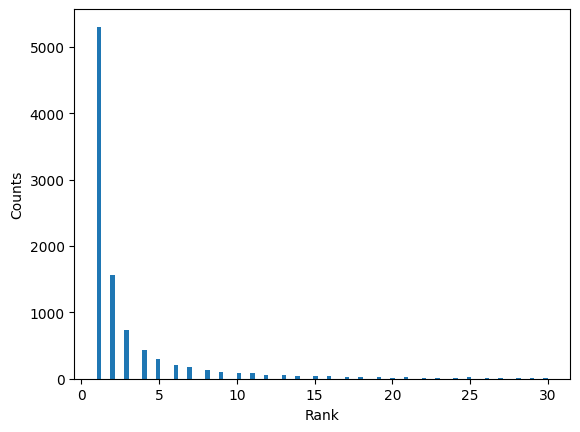

In [56]:
%matplotlib inline
arr = np.sort(rank_list)

plt.hist(arr[:int(arr.shape[0]*0.96)]+1, bins=100)
plt.xlabel("Rank")
plt.ylabel("Counts")
plt.show()

In [57]:
(arr <= 9).sum() / arr.shape[0] * 100

90.35

In [58]:
(arr <= 4).sum() / arr.shape[0] * 100

83.32000000000001

In [59]:
(arr <= 0).sum() / arr.shape[0] * 100

53.059999999999995